## Jianuo Liu

### Please run the code in Google Colab

In [18]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim.parsing import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import random
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [19]:
class Partition:
    def __init__(self):
      nltk.download('gutenberg')
      nltk.download('punkt')
      nltk.download('stopwords')
      self.books = nltk.corpus.gutenberg.fileids()
      self.text = None
      self.words = None
      self.sentence = None
      self.chunks = []
      self.df = None
      self.label_list = []
      self.encoder_nums = LabelEncoder()

    # get the full text content of the book    
    def getRawBook(self, bookName:str):
      self.text = nltk.corpus.gutenberg.raw(bookName)
      author = self.getAuthor()
      self.text = self.text.lower()
      return author
    
    # remove the punctuation and stopwords, only keep the words with meaning
    def tokenize(self, removePunc = False, removeStop = False):
      if self.text != None:
        if removePunc:
          #tokenizer = RegexpTokenizer(r'\w+')
          self.text = preprocessing.strip_punctuation(self.text)
        if removeStop:
          self.text = preprocessing.remove_stopwords(self.text)
        self.words = nltk.word_tokenize(self.text)
      else:
        print("text is null, tokenize should be invoked after getRawBook.")
      
        

    # extract the author from each book        
    def getAuthor(self):
        text = nltk.sent_tokenize(self.text)[0]
        regex = r"((?<= by).*?(?=[\d\]]+))"
        match = re.search(regex, text)
        author = None
        if(match != None):
            author = match.group().strip()
            print("if: " + author)
        else:
            regex = r"(?<=\[).*?(?=\])"
            match = re.search(regex, text)
            author = match.group().strip()
            print("else: " + author)   
        return author
    
    # chunk the words by 200 partitions and then randomly pick 100 words in each partition.
    # add author to the end of each 100 words record
    def chunkize(self, author):
      chunk = []
      label_list = []
      for i in range(200):
        randomStart = random.randint(0, len(self.words) - 100)
        words100 = self.words[randomStart:randomStart+100]
        # words100 = map(str.lower, words100)
            # words100.append(author)
        label_list.append(author)
        string = ' '.join(words100)
        self.chunks.append(string)
      #self.chunks.extend(chunk)
      self.label_list.extend(label_list)
    
    # replace the author name at the end with one-hot binary numbers or real number to be the label (groups from the same book will have the same label)
    def oneHotLabel(self, oneHot=True):
      label_nums = self.encoder_nums.fit_transform(self.label_list)
      categories = list(self.encoder_nums.classes_)
      label_nums = np.array([label_nums]).T
      encoder_one_hot = OneHotEncoder()
      label_one_hot = encoder_one_hot.fit_transform(label_nums)
      label_one_hot = label_one_hot.toarray()
      print(np.array(self.chunks).shape, label_one_hot.shape, label_nums.shape)
      if not oneHot:
        return model_selection.train_test_split(self.chunks, label_nums, test_size=0.2, random_state=1024)
      else:
        return model_selection.train_test_split(self.chunks, label_one_hot, test_size=0.2, random_state=1024)
    
    def buildDF(self):
      npChunks = np.array(self.chunks)
      print(npChunks.shape)
      data = npChunks.reshape((1000, 100))
      print(data.shape)
      self.df = pd.DataFrame(data)
        

In [20]:
partition = Partition()
books = ['austen-emma.txt','carroll-alice.txt','chesterton-ball.txt','burgess-busterbrown.txt','melville-moby_dick.txt']

for book in books:
  print(book)
  author = partition.getRawBook(book)
  partition.tokenize(removePunc = True, removeStop = True)
  partition.chunkize(author)
#partition.buildDF()
#df = partition.df

X_train, X_test, y_train_onehot, y_test_onehot = partition.oneHotLabel()
#print(X_train[0:10])
X_train, X_test, y_train_num, y_test_num = partition.oneHotLabel(oneHot=False)
#df.head()
#print(X_train[0:10])
#print(y_train_num)

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
austen-emma.txt
if: Jane Austen
carroll-alice.txt
if: Lewis Carroll
chesterton-ball.txt
if: G.K. Chesterton
burgess-busterbrown.txt
if: Thornton W. Burgess
melville-moby_dick.txt
if: Herman Melville
(1000,) (1000, 5) (1000, 1)
(1000,) (1000, 5) (1000, 1)


In [21]:
class FeatureModel:
    def __init__(self, X_train, X_test, ):
      self.X_train = X_train
      self.X_test = X_test
      self.modelName = None
      self.freqMatrix = None
      self.bag = None
      self.X = None
      self.vec = None
      self.tfidf = None
      self.transformer = None
    
    def toBOW(self):
      self.vec = CountVectorizer()
      #X_train_vec = self.vec.fit_transform([j for i in self.X_train for j in i])
      #X_test_vec = self.vec.transform([j for i in self.X_test for j in i])
      X_train_vec = self.vec.fit_transform(self.X_train)
      X_test_vec = self.vec.transform(self.X_test)
      return X_train_vec, X_test_vec
        
    def toTFIDF(self):
    #   self.vec = CountVectorizer()
    #   X_train_count = self.vec.fit_transform([j for i in self.X_train for j in i])
    #   X_test_count = self.vec.transform([j for i in self.X_test for j in i])
    #   vectorizer = TfidfTransformer(max_df=0.9)
    #   X_train_vec = vectorizer.fit_transform(X_train_count)
    #   #print(X_train_vec)
    #   X_test_vec = vectorizer.transform(X_test_count)
      self.vec = TfidfVectorizer(max_df=0.9)
      #X_train_vec = self.vec.fit_transform([j for i in self.X_train for j in i])
      #X_test_vec = self.vec.transform([j for i in self.X_test for j in i])
      X_train_vec = self.vec.fit_transform(self.X_train)
      X_test_vec = self.vec.transform(self.X_test)
      return X_train_vec, X_test_vec
        
    def toNGram(self):
      self.vec = CountVectorizer(min_df = 1, ngram_range = (1,2))#, analyzer="char_wb")
      #X_train_vec = self.vec.fit_transform([j for i in self.X_train for j in i])
      #X_test_vec = self.vec.transform([j for i in self.X_test for j in i])
      X_train_vec = self.vec.fit_transform(self.X_train)
      X_test_vec = self.vec.transform(self.X_test)
      return X_train_vec, X_test_vec




In [22]:
# Feature test

featureModel = FeatureModel(X_train, X_test)
X_train_TFIDF, X_test_TFIDF = featureModel.toTFIDF()
X_train_BOW, X_test_BOW = featureModel.toBOW()
X_train_NG, X_test_NG = featureModel.toNGram()
print(np.sum(X_test_TFIDF.toarray()), np.sum(X_test_BOW.toarray()), np.sum(X_test_NG.toarray()))
print(X_train_BOW.toarray().shape, X_train_TFIDF.toarray().shape, X_test_BOW.toarray().shape, X_test_TFIDF.toarray().shape)
# print(X_train_BOW.toarray()[0, 100:1100])
# print(X_train_TFIDF.toarray()[0, 100:1100])
# print(X_train_NG.toarray()[0, 100:1100])

1515.8284366471003 18337 29136
(800, 10822) (800, 10822) (200, 10822) (200, 10822)


In [23]:
class Model:
    def __init__(self, traindata, trainlabel, modelName:str):
        self.x = traindata
        self.y = trainlabel.reshape((trainlabel.shape[0],))
        #print(self.x)
        #print(self.y)
        self.modelName = modelName
        self.kf = KFold(n_splits = 10)
        self.clf = None
        if self.modelName == 'DecisionTree':
          self.DecisionTree()
        elif self.modelName == 'SVM':
          self.SVM()
        elif self.modelName == 'KNN':
          self.KNN()
        
    
    def SVM(self):
        self.clf = svm.SVC(kernel="linear")
        scores = cross_val_score(self.clf, self.x, self.y, cv=10)
        print("scores:",scores)
        print("scores mean:", scores.mean())
        self.clf.fit(self.x, self.y)
    

    def DecisionTree(self):
        self.clf = tree.DecisionTreeClassifier()
        scores = cross_val_score(self.clf, self.x, self.y, cv=10)
        print("scores:",scores)
        print("scores mean:", scores.mean())
        self.clf.fit(self.x, self.y)         

    
    def KNN(self):
        self.clf = KNeighborsClassifier(n_neighbors=3)
        scores = cross_val_score(self.clf, self.x, self.y, cv=10)
        print("scores:",scores)
        print("scores mean:", scores.mean())
        self.clf.fit(self.x, self.y)

        

In [24]:
# TFIDF transformation: scores and report 
featureModel = FeatureModel(X_train, X_test)
X_train_TFIDF, X_test_TFIDF = featureModel.toTFIDF()
authors = list(partition.encoder_nums.classes_)

model_TFIDF_DT = Model(X_train_TFIDF.reshape((800,-1)).tocsr(), y_train_num, 'DecisionTree')
predicted_DT = model_TFIDF_DT.clf.predict(X_test_TFIDF.tocsr())
# print(predicted_DT)
# print(partition.encoder_nums.inverse_transform(predicted_DT))
print(metrics.classification_report(y_test_num, predicted_DT, target_names=authors))


model_TFIDF_SVM = Model(X_train_TFIDF.reshape((800,-1)).tocsr(), y_train_num.reshape((800,)), 'SVM')
predicted_SVM = model_TFIDF_SVM.clf.predict(X_test_TFIDF.tocsr())
# print(predicted_SVM)
# print(partition.encoder_nums.inverse_transform(predicted_SVM))
print(metrics.classification_report(y_test_num, predicted_SVM, target_names=authors))

model_TFIDF_KNN = Model(X_train_TFIDF.reshape((800,-1)).tocsr(), y_train_num, 'KNN')
predicted_KNN = model_TFIDF_KNN.clf.predict(X_test_TFIDF.tocsr())
# print(predicted_KNN)
# print(partition.encoder_nums.inverse_transform(predicted_KNN))
print(metrics.classification_report(y_test_num, predicted_KNN, target_names=authors))




scores: [0.9625 0.95   0.9625 0.95   0.9    0.925  0.95   0.9    0.9625 0.975 ]
scores mean: 0.94375
                     precision    recall  f1-score   support

    G.K. Chesterton       0.89      0.93      0.91        42
    Herman Melville       0.84      0.84      0.84        31
        Jane Austen       0.91      0.93      0.92        45
      Lewis Carroll       1.00      0.93      0.97        45
Thornton W. Burgess       1.00      1.00      1.00        37

           accuracy                           0.93       200
          macro avg       0.93      0.93      0.93       200
       weighted avg       0.93      0.93      0.93       200

scores: [1.     0.975  1.     1.     1.     0.9875 1.     0.975  1.     1.    ]
scores mean: 0.99375
                     precision    recall  f1-score   support

    G.K. Chesterton       1.00      1.00      1.00        42
    Herman Melville       1.00      1.00      1.00        31
        Jane Austen       1.00      1.00      1.00        45
 

In [25]:
# Error analysis 
print('DT Bias: ')
TFIDT_DT_Bias = np.mean((y_test_num.reshape((200,)) - predicted_DT)**2)
print(TFIDT_DT_Bias)
print('DT Variance: ')
TFIDT_DT_Var = np.var(predicted_DT)
print(TFIDT_DT_Var)

print('SVM Bias: ')
TFIDT_SVM_Bias = np.mean((y_test_num.reshape((200,)) - predicted_SVM)**2)
print(TFIDT_SVM_Bias)
print('SVM Variance: ')
TFIDT_SVM_Var = np.var(predicted_SVM)
print(TFIDT_SVM_Var)

print('KNN Bias: ')
TFIDT_KNN_Bias = np.mean((y_test_num.reshape((200,)) - predicted_KNN)**2)
print(TFIDT_KNN_Bias)
print('KNN Variance: ')
TFIDT_KNN_Var = np.var(predicted_KNN)
print(TFIDT_KNN_Var)

DT Bias: 
0.185
DT Variance: 
1.9847750000000002
SVM Bias: 
0.0
SVM Variance: 
1.9595999999999998
KNN Bias: 
0.155
KNN Variance: 
1.909375


In [26]:
# BOW transformation: scores and report
featureModel = FeatureModel(X_train, X_test)
X_train_BOW, X_test_BOW = featureModel.toBOW()
authors = list(partition.encoder_nums.classes_)

model_BOW_DT = Model(X_train_BOW.reshape((800,-1)).tocsr(), y_train_num, 'DecisionTree')
predicted_DT = model_BOW_DT.clf.predict(X_test_BOW.reshape(200,-1).tocsr())
# print(predicted_DT)
# print(partition.encoder_nums.inverse_transform(predicted_DT))
print(metrics.classification_report(y_test_num, predicted_DT, target_names=authors))


model_BOW_SVM = Model(X_train_BOW.reshape((800,-1)).tocsr(), y_train_num.reshape((800,)), 'SVM')
predicted_SVM = model_BOW_SVM.clf.predict(X_test_BOW.reshape(200,-1).tocsr())
# print(predicted_SVM)
# print(partition.encoder_nums.inverse_transform(predicted_SVM))
print(metrics.classification_report(y_test_num, predicted_SVM, target_names=authors))

model_BOW_KNN = Model(X_train_BOW.reshape((800,-1)).tocsr(), y_train_num, 'KNN')
predicted_KNN = model_BOW_KNN.clf.predict(X_test_BOW.reshape(200,-1).tocsr())
# print(predicted_KNN)
# print(partition.encoder_nums.inverse_transform(predicted_KNN))
print(metrics.classification_report(y_test_num, predicted_KNN, target_names=authors))





scores: [0.975  0.9625 0.95   0.9375 0.9    0.925  0.9625 0.925  0.95   0.9375]
scores mean: 0.9425000000000001
                     precision    recall  f1-score   support

    G.K. Chesterton       0.95      0.88      0.91        42
    Herman Melville       0.82      0.90      0.86        31
        Jane Austen       0.94      0.98      0.96        45
      Lewis Carroll       0.98      0.93      0.95        45
Thornton W. Burgess       1.00      1.00      1.00        37

           accuracy                           0.94       200
          macro avg       0.94      0.94      0.94       200
       weighted avg       0.94      0.94      0.94       200

scores: [1.     0.9875 0.9875 1.     1.     0.9875 1.     0.9875 1.     1.    ]
scores mean: 0.9949999999999999
                     precision    recall  f1-score   support

    G.K. Chesterton       1.00      0.98      0.99        42
    Herman Melville       0.94      1.00      0.97        31
        Jane Austen       1.00      1.00

In [27]:
# Error analysis 

print('DT Bias: ')
BOW_DT_Bias = np.mean((y_test_num.reshape((200,)) - predicted_DT)**2)
print(BOW_DT_Bias)
print('DT Variance: ')
BOW_DT_Var = np.var(predicted_DT)
print(BOW_DT_Var)

print('SVM Bias: ')
BOW_SVM_Bias = np.mean((y_test_num.reshape((200,)) - predicted_SVM)**2)
print(BOW_SVM_Bias)
print('SVM Variance: ')
BOW_SVM_Var = np.var(predicted_SVM)
print(BOW_SVM_Var)

print('KNN Bias: ')
BOW_KNN_Bias = np.mean((y_test_num.reshape((200,)) - predicted_KNN)**2)
print(BOW_KNN_Bias)
print('KNN Variance: ')
BOW_KNN_Var = np.var(predicted_KNN)
print(BOW_KNN_Var)


DT Bias: 
0.185
DT Variance: 
1.904375
SVM Bias: 
0.025
SVM Variance: 
1.9447750000000001
KNN Bias: 
0.08
KNN Variance: 
1.9699


In [28]:
# NGram transformation: scores and report
featureModel = FeatureModel(X_train, X_test)
X_train_NGram, X_test_NGram = featureModel.toNGram()
authors = list(partition.encoder_nums.classes_)

model_NGram_DT = Model(X_train_NGram.reshape((800,-1)).tocsr(), y_train_num, 'DecisionTree')
predicted_DT = model_NGram_DT.clf.predict(X_test_NGram.reshape(200,-1).tocsr())
# print(predicted_DT)
# print(partition.encoder_nums.inverse_transform(predicted_DT))
print(metrics.classification_report(y_test_num, predicted_DT, target_names=authors))



model_NGram_SVM = Model(X_train_NGram.reshape((800,-1)).tocsr(), y_train_num.reshape((800,)), 'SVM')
predicted_SVM = model_NGram_SVM.clf.predict(X_test_NGram.reshape(200,-1).tocsr())
# print(predicted_SVM)
# print(partition.encoder_nums.inverse_transform(predicted_SVM))
print(metrics.classification_report(y_test_num, predicted_SVM, target_names=authors))
# print(metrics.confusion_matrix(y_test_num, predicted_SVM))

model_NGram_KNN = Model(X_train_NGram.reshape((800,-1)).tocsr(), y_train_num, 'KNN')
predicted_KNN = model_NGram_KNN.clf.predict(X_test_NGram.reshape(200,-1).tocsr())
# print(predicted_KNN)
# print(partition.encoder_nums.inverse_transform(predicted_KNN))
print(metrics.classification_report(y_test_num, predicted_KNN, target_names=authors))





scores: [0.95   0.975  0.975  0.9375 0.925  0.925  0.95   0.9125 0.975  0.925 ]
scores mean: 0.9450000000000001
                     precision    recall  f1-score   support

    G.K. Chesterton       0.95      0.93      0.94        42
    Herman Melville       0.80      0.90      0.85        31
        Jane Austen       0.93      0.93      0.93        45
      Lewis Carroll       1.00      0.93      0.97        45
Thornton W. Burgess       1.00      1.00      1.00        37

           accuracy                           0.94       200
          macro avg       0.94      0.94      0.94       200
       weighted avg       0.94      0.94      0.94       200

scores: [1.     0.975  0.975  1.     1.     0.975  1.     0.9875 1.     1.    ]
scores mean: 0.9912500000000002
                     precision    recall  f1-score   support

    G.K. Chesterton       1.00      0.95      0.98        42
    Herman Melville       0.91      1.00      0.95        31
        Jane Austen       1.00      1.00

In [29]:
# Error analysis 


print('DT Bias: ')
NGram_DT_Bias = np.mean((y_test_num.reshape((200,)) - predicted_DT)**2)
print(NGram_DT_Bias)
print('DT Variance: ')
NGram_DT_Var = np.var(predicted_DT)
print(NGram_DT_Var)

print('SVM Bias: ')
NGram_SVM_Bias = np.mean((y_test_num.reshape((200,)) - predicted_SVM)**2)
print(NGram_SVM_Bias)
print('SVM Variance: ')
NGram_SVM_Var = np.var(predicted_SVM)
print(NGram_SVM_Var)

print('KNN Bias: ')
NGram_KNN_Bias = np.mean((y_test_num.reshape((200,)) - predicted_KNN)**2)
print(NGram_KNN_Bias)
print('KNN Variance: ')
NGram_KNN_Var = np.var(predicted_KNN)
print(NGram_KNN_Var)

DT Bias: 
0.145
DT Variance: 
1.9449750000000001
SVM Bias: 
0.03
SVM Variance: 
1.9295999999999998
KNN Bias: 
0.15
KNN Variance: 
1.9875000000000003


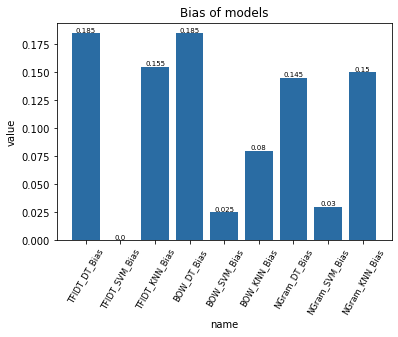

In [30]:
# visualizing bias value of the prediction results
fig, ax = plt.subplots()

num_list = [TFIDT_DT_Bias,TFIDT_SVM_Bias,TFIDT_KNN_Bias,BOW_DT_Bias,BOW_SVM_Bias,BOW_KNN_Bias,NGram_DT_Bias,NGram_SVM_Bias,NGram_KNN_Bias]

name_list = ['TFIDT_DT_Bias','TFIDT_SVM_Bias','TFIDT_KNN_Bias','BOW_DT_Bias','BOW_SVM_Bias','BOW_KNN_Bias','NGram_DT_Bias','NGram_SVM_Bias','NGram_KNN_Bias',]
b = ax.bar(name_list, num_list)

plt.bar(range(len(num_list)), num_list,color=(0.2, 0.4, 0.6, 0.6),tick_label=name_list)
plt.xticks(size='small',rotation=60)
plt.title('Bias of models')
plt.xlabel('name')
plt.ylabel('value')

for a, b in zip(name_list,num_list):

    ax.text(a, b, b, ha='center', va='bottom', fontsize=7,) 

plt.show()

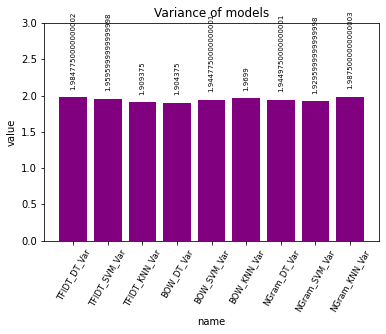

In [31]:
# visualizing variance value of the prediction results
fig, ax = plt.subplots()


num_list = [TFIDT_DT_Var,TFIDT_SVM_Var,TFIDT_KNN_Var,BOW_DT_Var,BOW_SVM_Var,BOW_KNN_Var,NGram_DT_Var,NGram_SVM_Var,NGram_KNN_Var]

name_list = ['TFIDT_DT_Var','TFIDT_SVM_Var','TFIDT_KNN_Var','BOW_DT_Var','BOW_SVM_Var','BOW_KNN_Var','NGram_DT_Var','NGram_SVM_Var','NGram_KNN_Var',]
b = ax.bar(name_list, num_list)

plt.bar(range(len(num_list)), num_list,color='purple',tick_label=name_list)
ax.set(ylim=[0,3])

plt.xticks(size='small',rotation=60)
plt.title('Variance of models')
plt.xlabel('name')
plt.ylabel('value')

for a,b in zip(name_list,num_list):

    ax.text(a, b+0.1, b, ha='center', va='bottom', fontsize=7, rotation=90) 

plt.show()

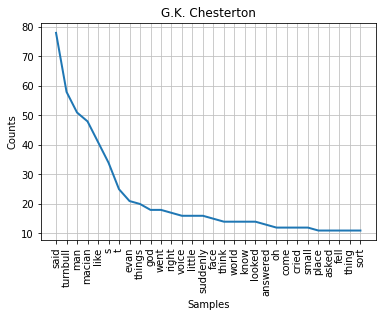

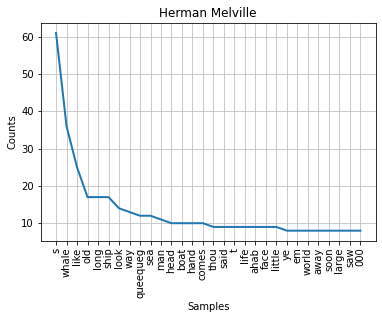

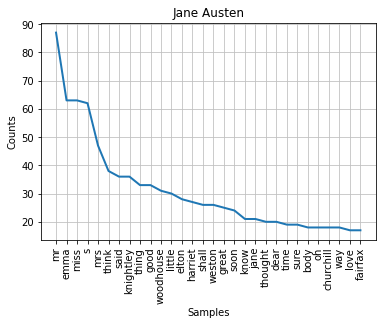

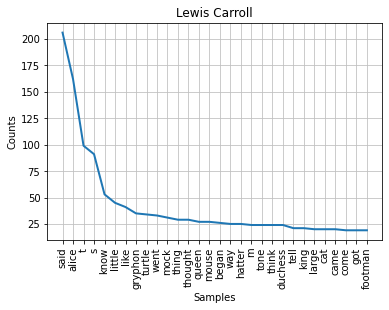

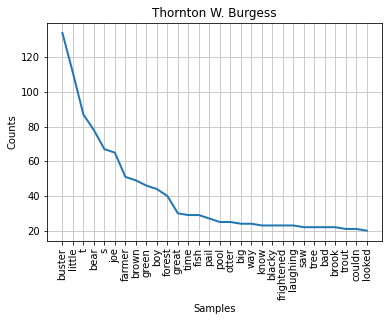

In [32]:
# visualizing the words frequency of each book after cleansing
authors = list(partition.encoder_nums.classes_)

fdist = []
fdist.append([])
fdist.append([])
fdist.append([])
fdist.append([])
fdist.append([])

from nltk.probability import FreqDist
import matplotlib.pyplot as plt
index = 0

for i in range(len(X_test)):
  index = y_test_num[i][0]
  fdist[index].append(X_test[i])

for i in range(5):
  fdist[i] = " ".join(fdist[i])
  fdist[i] = fdist[i].split(" ")

  fdistt = FreqDist(fdist[i])  

  plt.title(authors[i])
  plt.xlabel("Word")
  plt.ylabel("Frequency")
  fdistt.plot(30,cumulative=False)


  plt.show()

